# Interatively run array ephys workflow

This notebook walks you through the steps in detail to run the ephys workflow.  

+ If you need a more automatic approach to run the workflow, refer to [03-automate](03-automate.ipynb)
+ The workflow requires neuropixels meta file and kilosort output data. If you haven't configure the paths, refer to [01-configure](01-configure.ipynb)
+ To overview the schema structures, refer to [02-workflow-structure](02-workflow-structure.ipynb)

Let's will change the directory to the package root to load configuration and also import relevant schemas.

In [1]:
import os
os.chdir('..')

In [2]:
import datajoint as dj
from workflow_array_ephys.pipeline import lab, subject, session, probe, ephys

Connecting root@localhost:3306


## Ingestion of metadata: subjects, sessions, probes, and probe insertions

The first step to run through the workflow is to insert metadata into the following tables:

+ subject.Subject: an animal subject for experiments
+ session.Session: an experimental session performed on an animal subject
+ session.SessionDirectory: directory to the data for a given experimental session
+ probe.Probe: probe information
+ ephys.ProbeInsertion: probe insertion into an animal subject during a given experimental session

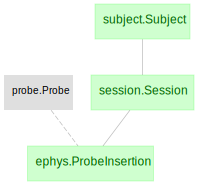

In [3]:
dj.Diagram(subject.Subject) + dj.Diagram(session.Session) + dj.Diagram(probe.Probe) + dj.Diagram(ephys.ProbeInsertion)

Our example dataset is for subject6, session1.

### Ingest Subject

In [6]:
subject.Subject.heading

# Animal Subject
subject              : varchar(32)                  # 
---
sex                  : enum('M','F','U')            # 
subject_birth_date   : date                         # 
subject_description="" : varchar(1024)                # 

In [7]:
# insert entries with insert1() or insert(), with all required attributes specified in a dictionary
subject.Subject.insert1(
    dict(subject='subject6', sex='M', subject_birth_date='2020-01-04'),
    skip_duplicates=True) # skip_duplicates avoids error when inserting entries with duplicated primary keys
subject.Subject()

subject,sex,subject_birth_date,subject_description
subject6,M,2020-01-04,


### Ingest Session

In [8]:
session.Session.describe();

-> subject.Subject
session_datetime     : datetime(3)                  



In [9]:
session.Session.heading

# 
subject              : varchar(32)                  # 
session_datetime     : datetime(3)                  # 

In [10]:
session_key = dict(subject='subject6', session_datetime='2021-01-15 11:16:38')
session.Session.insert1(session_key, skip_duplicates=True)
session.Session()

subject,session_datetime
subject6,2021-01-15 11:16:38


### Ingest SessionDirectory

In [11]:
session.SessionDirectory.describe();

-> session.Session
---
session_dir          : varchar(256)                 # Path to the data directory for a particular session



In [12]:
session.SessionDirectory.heading

# 
subject              : varchar(32)                  # 
session_datetime     : datetime(3)                  # 
---
session_dir          : varchar(256)                 # Path to the data directory for a particular session

In [13]:
session.SessionDirectory.insert1(
    dict(subject='subject6', session_datetime='2021-01-15 11:16:38',
         session_dir='subject6/session1'),
    skip_duplicates=True)
session.SessionDirectory()

subject,session_datetime,session_dir Path to the data directory for a particular session
subject6,2021-01-15 11:16:38,subject6/session1


**Note**:  

the `session_dir` needs to be:
+ a directory **relative to** the `ephys_root_path` in the configuration file, refer to [01-configure](01-configure.ipynb) for more information.
+ a directory in POSIX format (Unix/Linux), with `/`, the difference in Operating system will be taken care of by the elements.

### Ingest Probe

In [14]:
probe.Probe.heading

# Represent a physical probe with unique identification
probe                : varchar(32)                  # unique identifier for this model of probe (e.g. serial number)
---
probe_type           : varchar(32)                  # e.g. neuropixels_1.0
probe_comment=""     : varchar(1000)                # 

In [15]:
probe.Probe.insert1(
    dict(probe='17131311651', probe_type='neuropixels 1.0 - 3B'),
    skip_duplicates=True) # this info could be achieve from neuropixels meta file.
probe.Probe()

probe unique identifier for this model of probe (e.g. serial number),probe_type e.g. neuropixels_1.0,probe_comment
17131311651,neuropixels 1.0 - 3B,


### Ingest ProbeInsertion

In [16]:
ephys.ProbeInsertion.describe();

# Probe insertion implanted into an animal for a given session.
-> session.Session
insertion_number     : tinyint unsigned             
---
-> probe.Probe



In [17]:
ephys.ProbeInsertion.heading

# Probe insertion implanted into an animal for a given session.
subject              : varchar(32)                  # 
session_datetime     : datetime(3)                  # 
insertion_number     : tinyint unsigned             # 
---
probe                : varchar(32)                  # unique identifier for this model of probe (e.g. serial number)

In [18]:
ephys.ProbeInsertion.insert1(
    dict(subject='subject6', session_datetime="2021-01-15 11:16:38",
         insertion_number=0, probe='17131311651'),
    skip_duplicates=True)  # probe, subject, session_datetime needs to follow the restrictions of foreign keys.
ephys.ProbeInsertion()

subject,session_datetime,insertion_number,probe unique identifier for this model of probe (e.g. serial number)
subject6,2021-01-15 11:16:38,0,17131311651


## Automate this manual step

In this workflow, these manual steps could be automated by:
1. Insert entries in files `/user_data/subjects.csv` and `/user_data/session.csv`
2. Extract user-specified information from `/user_data/subjects.csv` and `/user_data/sessions.csv` and insert to Subject and Session tables by running:
```
from workflow_array_ephys.ingest import ingest_subjects, ingest_sessions
ingest_subjects()
ingest_sessions()
```
`ingest_sessions` also extracts probe and probe insertion information automatically from the meta file.

This is the regular routine for daily data processing, illustrated in notebook [04-automate](04-automate[optional].ipynb).

## Populate EphysRecording

Now we are ready to populate EphysRecording, a table for entries of ephys recording in a particular session.

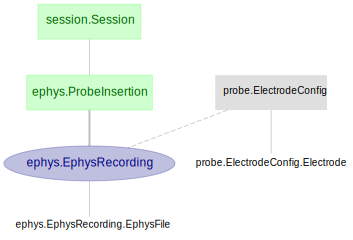

In [19]:
dj.Diagram(session.Session) + \
(dj.Diagram(probe.ElectrodeConfig) + 1) + \
dj.Diagram(ephys.EphysRecording) + dj.Diagram(ephys.EphysRecording.EphysFile)
# +1 means plotting 1 more layer of the child tables

In [20]:
# The first argument specify a particular session to populate
ephys.EphysRecording.populate(session_key, display_progress=True)

EphysRecording: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.84s/it]


Populate EphysRecording extracts the following information from .ap.meta file from SpikeGLX:

1. **probe.EelectrodeConfig**: this procedure detects new ElectrodeConfig, i.e. which 384 electrodes out of the total 960 on the probe were used in this ephys session, and save the results into the table `probe.EelectrodeConfig`. Each entry in table `ephys.EphysRecording` specifies which ElectrodeConfig is used in a particular ephys session. 

For this ephys session we just populated, Electrodes 0-383 was used.

In [21]:
probe.ElectrodeConfig()

electrode_config_hash,probe_type e.g. neuropixels_1.0,electrode_config_name user friendly name
6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,0-383


In [22]:
probe.ElectrodeConfig.Electrode()

electrode_config_hash,probe_type e.g. neuropixels_1.0,"electrode electrode index, starts at 0"
6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,0
6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,1
6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,2
6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,3
6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,4
6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,5
6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,6


2. **ephys.EphysRecording**: note here that it refers to a particular electrode_config identified with a hash.

In [23]:
ephys.EphysRecording() & session_key

subject,session_datetime,insertion_number,electrode_config_hash,acq_software,sampling_rate (Hz)
subject6,2021-01-15 11:16:38,0,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,SpikeGLX,30000.6


3. **ephys_element.EphysRecording.EphysFile**

The table `EphysFile` only saves the meta file from the recording

In [24]:
ephys.EphysRecording.EphysFile() & session_key

subject,session_datetime,insertion_number,file_path filepath relative to root data directory
subject6,2021-01-15 11:16:38,0,subject6/session1/towersTask_g0_imec0/towersTask_g0_t0.imec0.ap.meta


## Create ClusteringTask and run/validate Clustering

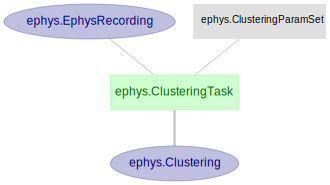

In [25]:
dj.Diagram(ephys.EphysRecording) + ephys.ClusteringParamSet + ephys.ClusteringTask + \
ephys.Clustering

The next major table in the ephys pipeline is the `ClusteringTask`.

+ An entry in `ClusteringTask` indicates a set of clustering results generated from Kilosort2 outside `workflow-array-ephys` are ready be ingested. In a future release, an entry in `ClusteringTask` can also indicate a new Kilosort2 clustering job is ready to be triggered. 

+ The `ClusteringTask` table depends on the table `ClusteringParamSet`, which are the parameters of the clustering task and needed to be ingested first. 

A method of the class `ClusteringParamSet` called `insert_new_params` helps on the insertion of a parameter set and ensures the inserted one is not duplicated with existing parameter sets in the database.

The following parameters' values are set based on [Kilosort StandardConfig file](https://github.com/MouseLand/Kilosort/tree/main/configFiles)

In [26]:
# insert clustering task manually
params_ks = {
    "fs": 30000,
    "fshigh": 150,
    "minfr_goodchannels": 0.1,
    "Th": [10, 4],
    "lam": 10,
    "AUCsplit": 0.9,
    "minFR": 0.02,
    "momentum": [20, 400],
    "sigmaMask": 30,
    "ThPr": 8,
    "spkTh": -6,
    "reorder": 1,
    "nskip": 25,
    "GPU": 1,
    "Nfilt": 1024,
    "nfilt_factor": 4,
    "ntbuff": 64,
    "whiteningRange": 32,
    "nSkipCov": 25,
    "scaleproc": 200,
    "nPCs": 3,
    "useRAM": 0
}
ephys.ClusteringParamSet.insert_new_params(
    processing_method='kilosort2',
    paramset_idx=0,
    params=params_ks,
    paramset_desc='Spike sorting using Kilosort2')
ephys.ClusteringParamSet()

paramset_idx,clustering_method,paramset_desc,param_set_hash,params dictionary of all applicable parameters
0,kilosort2,Spike sorting using Kilosort2,83f93e90-d8e0-1dca-5b2c-f65e2b0b3c61,=BLOB=


We are then able to insert an entry into the `ClusteringTask` table. One important field of the table is `clustering_output_dir`, which specifies the Kilosort2 output directory for the later processing.  
**Note**: this output dir is a relative path to be combined with `ephys_root_directory` in the config file.

In [27]:
ephys.ClusteringTask.describe();

# Manual table for defining a clustering task ready to be run
-> ephys.EphysRecording
-> ephys.ClusteringParamSet
---
clustering_output_dir : varchar(255)                 # clustering output directory relative to the clustering root data directory
task_mode="load"     : enum('load','trigger')       # 'load': load computed analysis results, 'trigger': trigger computation



In [28]:
ephys.ClusteringTask.heading

# Manual table for defining a clustering task ready to be run
subject              : varchar(32)                  # 
session_datetime     : datetime(3)                  # 
insertion_number     : tinyint unsigned             # 
paramset_idx         : smallint                     # 
---
clustering_output_dir : varchar(255)                 # clustering output directory relative to the clustering root data directory
task_mode="load"     : enum('load','trigger')       # 'load': load computed analysis results, 'trigger': trigger computation

In [29]:
ephys.ClusteringTask.insert1(
    dict(session_key, insertion_number=0, paramset_idx=0,
         clustering_output_dir='subject6/session1/towersTask_g0_imec0'),
    skip_duplicates=True)

In [30]:
ephys.ClusteringTask() & session_key

subject,session_datetime,insertion_number,paramset_idx,clustering_output_dir clustering output directory relative to the clustering root data directory,"task_mode 'load': load computed analysis results, 'trigger': trigger computation"
subject6,2021-01-15 11:16:38,0,0,subject6/session1/towersTask_g0_imec0,load


We are then able to populate the clustering results. The `Clustering` table now validates the Kilosort2 outcomes before ingesting the spike sorted results. In a future release of `element-array-ephys`, this table may be used to trigger a Kilosort2 process. A record in the `Clustering` indicates that Kilosort2 job is done successfully and the results are ready to be processed.

In [31]:
ephys.Clustering.populate(display_progress=True)

Clustering: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.75s/it]


In [32]:
ephys.Clustering() & session_key

subject,session_datetime,insertion_number,paramset_idx,clustering_time time of generation of this set of clustering results,package_version
subject6,2021-01-15 11:16:38,0,0,2021-02-22 23:07:16,


## Import clustering results and manually curated results

We are now ready to ingest the clustering results (spike times etc.) into the database. These clustering results are either directly from Kilosort2 or with manual curation. Both ways share the same format of files. In the element, there is a `Curation` table that saves this information.

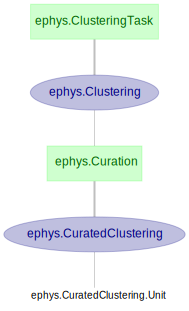

In [33]:
dj.Diagram(ephys.ClusteringTask) + dj.Diagram(ephys.Clustering) + dj.Diagram(ephys.Curation) + \
dj.Diagram(ephys.CuratedClustering) + dj.Diagram(ephys.CuratedClustering.Unit)

In [34]:
ephys.Curation.describe();

# Manual curation procedure
-> ephys.Clustering
curation_id          : int                          
---
curation_time        : datetime                     # time of generation of this set of curated clustering results
curation_output_dir  : varchar(255)                 # output directory of the curated results, relative to clustering root data directory
quality_control      : tinyint                      # has this clustering result undergone quality control?
manual_curation      : tinyint                      # has manual curation been performed on this clustering result?
curation_note=""     : varchar(2000)                



In [35]:
ephys.Curation.heading

# Manual curation procedure
subject              : varchar(32)                  # 
session_datetime     : datetime(3)                  # 
insertion_number     : tinyint unsigned             # 
paramset_idx         : smallint                     # 
curation_id          : int                          # 
---
curation_time        : datetime                     # time of generation of this set of curated clustering results
curation_output_dir  : varchar(255)                 # output directory of the curated results, relative to clustering root data directory
quality_control      : tinyint                      # has this clustering result undergone quality control?
manual_curation      : tinyint                      # has manual curation been performed on this clustering result?
curation_note=""     : varchar(2000)                # 

In [36]:
ephys.Curation.insert1(
    dict(session_key, insertion_number=0, paramset_idx=0,
         curation_id=1,
         curation_time='2021-04-28 15:47:01',
         curation_output_dir='subject6/session1/towersTask_g0_imec0',
         quality_control=0,
         manual_curation=0
        ))

In this case, the curation results are directly from Kilosort2 outputs, so the `curation_output_dir` is identical to `clustering_output_dir` in the table `ephys.ClusteringTask`. The `element-array-ephys` provides a helper function `ephys.Curation().create1_from_clustering_task` to conveniently insert an entry without manual curation.

Example usage:

```python
key = (ephys.ClusteringTask & session_key).fetch1('KEY')
ephys.Curation().create1_from_clustering_task(key)
```

Then we could populate table `CuratedClustering`, ingesting either the output of Kilosort2 or the curated results.

In [37]:
ephys.CuratedClustering.populate(session_key, display_progress=True)

CuratedClustering: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.73s/it]


The part table `CuratedClustering.Unit` contains the spike sorted units

In [38]:
ephys.CuratedClustering.Unit()

subject,session_datetime,insertion_number,paramset_idx,curation_id,unit,electrode_config_hash,probe_type e.g. neuropixels_1.0,"electrode electrode index, starts at 0",cluster_quality_label,spike_count how many spikes in this recording for this unit,"spike_times (s) spike times of this unit, relative to the start of the EphysRecording",spike_sites array of electrode associated with each spike,"spike_depths (um) array of depths associated with each spike, relative to the (0, 0) of the probe"
subject6,2021-01-15 11:16:38,0,0,1,0,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,0,mua,1227,=BLOB=,=BLOB=,=BLOB=
subject6,2021-01-15 11:16:38,0,0,1,1,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,0,mua,9390,=BLOB=,=BLOB=,=BLOB=
subject6,2021-01-15 11:16:38,0,0,1,2,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,2,mua,34,=BLOB=,=BLOB=,=BLOB=
subject6,2021-01-15 11:16:38,0,0,1,3,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,4,mua,4393,=BLOB=,=BLOB=,=BLOB=
subject6,2021-01-15 11:16:38,0,0,1,4,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,5,mua,5535,=BLOB=,=BLOB=,=BLOB=
subject6,2021-01-15 11:16:38,0,0,1,5,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,6,mua,20133,=BLOB=,=BLOB=,=BLOB=
subject6,2021-01-15 11:16:38,0,0,1,6,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,6,good,8519,=BLOB=,=BLOB=,=BLOB=


## Populate LFP

+ `LFP`: Mean local field potential across different electrodes.
+ `LFP.Electrode`: Local field potential of a given electrode.

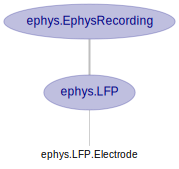

In [39]:
dj.Diagram(ephys.EphysRecording) + dj.Diagram(ephys.LFP) + dj.Diagram(ephys.LFP.Electrode)

In [40]:
# Takes a few minutes to populate
ephys.LFP.populate(session_key, display_progress=True)
ephys.LFP & session_key

LFP: 100%|██████████████████████████████████████████████████████████████████████████████| 1/1 [02:31<00:00, 151.23s/it]


subject,session_datetime,insertion_number,lfp_sampling_rate (Hz),lfp_time_stamps (s) timestamps with respect to the start of the recording (recording_timestamp),"lfp_mean (uV) mean of LFP across electrodes - shape (time,)"
subject6,2021-01-15 11:16:38,0,2500.05,=BLOB=,=BLOB=


In [41]:
ephys.LFP.Electrode & session_key

subject,session_datetime,insertion_number,electrode_config_hash,probe_type e.g. neuropixels_1.0,"electrode electrode index, starts at 0",lfp (uV) recorded lfp at this electrode
subject6,2021-01-15 11:16:38,0,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,5,=BLOB=
subject6,2021-01-15 11:16:38,0,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,14,=BLOB=
subject6,2021-01-15 11:16:38,0,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,23,=BLOB=
subject6,2021-01-15 11:16:38,0,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,32,=BLOB=
subject6,2021-01-15 11:16:38,0,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,41,=BLOB=
subject6,2021-01-15 11:16:38,0,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,50,=BLOB=
subject6,2021-01-15 11:16:38,0,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,59,=BLOB=


## Populate Spike Waveform

The current workflow also contain tables to save spike waveforms:
+ `WaveformSet`: a table to drive the processing of all spikes waveforms resulting from a CuratedClustering.
+ `WaveformSet.Waveform`: mean waveform across spikes for a given unit and electrode.
+ `WaveformSet.PeakWaveform`: mean waveform across spikes for a given unit at the electrode with peak spike amplitude.

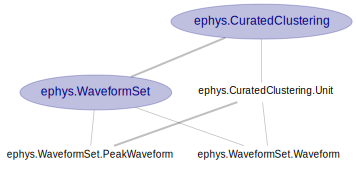

In [42]:
dj.Diagram(ephys.CuratedClustering) + dj.Diagram(ephys.WaveformSet) + 1

In [43]:
# Takes ~1h to populate for the test dataset
ephys.WaveformSet.populate(session_key, display_progress=True)

WaveformSet: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [28:14<00:00, 1694.99s/it]


In [44]:
ephys.WaveformSet & session_key

subject,session_datetime,insertion_number,paramset_idx,curation_id
subject6,2021-01-15 11:16:38,0,0,1


In [45]:
ephys.WaveformSet.Waveform & session_key

subject,session_datetime,insertion_number,paramset_idx,curation_id,unit,electrode_config_hash,probe_type e.g. neuropixels_1.0,"electrode electrode index, starts at 0",waveform_mean (uV) mean waveform across spikes of the given unit,waveforms (uV) (spike x sample) waveforms of a sampling of spikes at the given electrode for the given unit
subject6,2021-01-15 11:16:38,0,0,1,0,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,0,=BLOB=,=BLOB=
subject6,2021-01-15 11:16:38,0,0,1,0,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,1,=BLOB=,=BLOB=
subject6,2021-01-15 11:16:38,0,0,1,0,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,2,=BLOB=,=BLOB=
subject6,2021-01-15 11:16:38,0,0,1,0,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,3,=BLOB=,=BLOB=
subject6,2021-01-15 11:16:38,0,0,1,0,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,4,=BLOB=,=BLOB=
subject6,2021-01-15 11:16:38,0,0,1,0,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,5,=BLOB=,=BLOB=
subject6,2021-01-15 11:16:38,0,0,1,0,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,6,=BLOB=,=BLOB=


In [46]:
ephys.WaveformSet.PeakWaveform & session_key

subject,session_datetime,insertion_number,paramset_idx,curation_id,unit,peak_electrode_waveform (uV) mean waveform for a given unit at its representative electrode
subject6,2021-01-15 11:16:38,0,0,1,0,=BLOB=
subject6,2021-01-15 11:16:38,0,0,1,1,=BLOB=
subject6,2021-01-15 11:16:38,0,0,1,2,=BLOB=
subject6,2021-01-15 11:16:38,0,0,1,3,=BLOB=
subject6,2021-01-15 11:16:38,0,0,1,4,=BLOB=
subject6,2021-01-15 11:16:38,0,0,1,5,=BLOB=
subject6,2021-01-15 11:16:38,0,0,1,6,=BLOB=


## Summary and next step

This notebook walks through the detailed steps running the workflow. 

+ For an more automated way running the workflow, refer to [04-automate](04-automate-optional.ipynb)
+ In the next notebook [05-explore](05-explore.ipynb), we will introduce DataJoint methods to explore and visualize the ingested data.